In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import learning_curve

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics

import nltk
from nltk.corpus import stopwords
#from nltk.stem import SnowballStemmer

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

RANDOM_SEED = 42

# class StemCountVectorizer(CountVectorizer):
#     def build_analyzer(self):
#         analyzer = super(StemCountVectorizer, self).build_analyzer()
        
#         return lambda document: ([SnowballStemmer('english', ignore_stopwords=True).stem(word) for word in analyzer(document)])

In [2]:
mcu = pd.read_pickle("mcu_v2.pkl")

In [3]:
mcu.head()

,character,line,movie,year,Tony
0,TONY STARK,"Oh, I get it. You guys aren’t allowed to talk. Is that it? Are you not allowed to talk?",Iron Man,2008,1
1,IRON MAN JIMMY,No. We’re allowed to talk.,Iron Man,2008,0
2,TONY STARK,Oh. I see. So it’s personal.,Iron Man,2008,1
3,RAMIREZ,I think they’re intimidated.,Iron Man,2008,0
4,TONY STARK,"Good God, you’re a woman. I, honestly, I couldn’t have called that. I would apologize, but isn’t that what we’re going for here? I saw you as a soldier first.",Iron Man,2008,1


In [4]:
y = mcu.Tony
X = mcu["line"].to_numpy().astype(str)

In [5]:
cross_validator = StratifiedKFold(n_splits=10, random_state=RANDOM_SEED, shuffle=True)
score_method = "f1"

#stem_count_vectorizer = StemCountVectorizer(binary=False)
tfidf = TfidfVectorizer()
nb_classifier = MultinomialNB(alpha=0.01)

#count_params = {'vect__stop_words': [None, stopwords.words('english')],'vect__ngram_range': [(1,1), (1,2)]}

tfidf_params = {'tfidf__use_idf': [True, False]}

nb_params = {'clf__fit_prior': [True, False]}

pipe = Pipeline([('tfidf', tfidf),
                  ('clf', nb_classifier)])

parameters = {**tfidf_params, **nb_params}

model = GridSearchCV(pipe, parameters, cv=cross_validator, scoring=score_method, n_jobs=-1, verbose=6)

In [6]:
models = {"model 1": model}

cv_score_table = pd.DataFrame()

for name, model in models.items():
    results = cross_val_score(model, X, y, cv=cross_validator, scoring=score_method, n_jobs=-1, verbose=6)
    cv_score_table.insert(len(cv_score_table.columns), name, results, True)

cv_score_table.index.name = "fold"
cv_score_table.loc["mean"] = cv_score_table.mean()
cv_score_table.loc["std"] = cv_score_table.std()
cv_score_table.loc["max"] = cv_score_table.max()

cv_score_table

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   31.2s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   31.4s remaining:   31.4s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   31.5s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   44.3s finished


,model 1
fold,
0,0.263911
1,0.283247
2,0.305958
3,0.307692
4,0.243822
5,0.295798
6,0.247557
7,0.268212
8,0.318182


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   25.9s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   26.0s remaining:   26.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   26.4s remaining:   11.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   39.1s finished


Balanced Accuracy: 0.6152209557529852
Balanced Accuracy: 0.6152209557529852


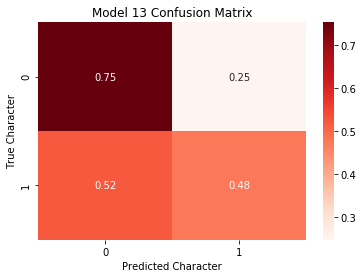

In [7]:
yhat = cross_val_predict(model, X, y, cv=cross_validator, n_jobs=-1, verbose=6)

main_characters = mcu['Tony'].value_counts().index.to_numpy()

conf_matrix = pd.DataFrame(metrics.confusion_matrix(y, yhat, labels=main_characters))
normalized_conf_matrix = conf_matrix.div(conf_matrix.sum(axis=1), axis=0)
normalized_conf_matrix.columns = pd.Series(main_characters, name="Predicted Character")
normalized_conf_matrix.index = pd.Series(main_characters, name="True Character")

plt.title("Model 13 Confusion Matrix")
sns.heatmap(normalized_conf_matrix, annot=True, fmt='.2f', cmap=plt.cm.Reds)

# Should be the same
print("Balanced Accuracy:", metrics.balanced_accuracy_score(y,yhat))
print("Balanced Accuracy:", np.mean(np.diagonal(normalized_conf_matrix)))

In [8]:
def plot_learning_curve(estimator, title, X, y, axes=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, verbose=6)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    plt.legend(loc="best")

    return

[learning_curve] Training set sizes: [ 1415  4599  7783 10967 14151]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  50 | elapsed:   15.5s remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  15 out of  50 | elapsed:   32.8s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  24 out of  50 | elapsed:   50.1s remaining:   54.3s
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed:  1.1min remaining:   34.9s
[Parallel(n_jobs=-1)]: Done  42 out of  50 | elapsed:  1.4min remaining:   16.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.7min finished


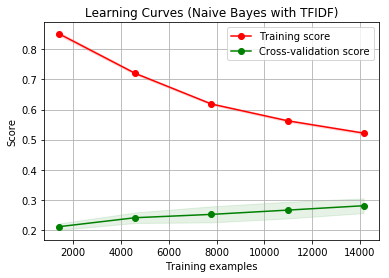

In [9]:
title = "Learning Curves (Naive Bayes with TFIDF)"

plot_learning_curve(model, title, X, y, cv=cross_validator)

In [10]:
model.fit(X,y)
prod_model = model.best_estimator_
dump(prod_model, './final_models/main_model.joblib')

prod_model

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  40 | elapsed:    3.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.8s finished


Pipeline(steps=[('tfidf', TfidfVectorizer(use_idf=False)),
                ('clf', MultinomialNB(alpha=0.01, fit_prior=False))])

In [11]:
model.best_params_

{'clf__fit_prior': False, 'tfidf__use_idf': False}

In [17]:
prod_model.named_steps

{'tfidf': TfidfVectorizer(use_idf=False),
 'clf': MultinomialNB(alpha=0.01, fit_prior=False)}